# Тask 1

We need to retrain our baseline, make it possible to clasify images on white background.

# Importing libraries

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import warnings
warnings.filterwarnings("ignore")
import gc

plt.ion() 

In [3]:
torch.__version__

'1.10.1'

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Readying labels for training

In [5]:
SOURCE_PATH = 'C:\PythonDev\Projects\sex_clothes_classifier\data\_data\_data'

### Подготовка датасета Ламоды

In [6]:
images_lamoda = os.listdir(f"{SOURCE_PATH}\lamoda\images")
print(f"Images count in lamoda dataset: {len(images_lamoda)}")

Images count in lamoda dataset: 916


In [7]:
lamoda_labels = pd.read_csv(f'{SOURCE_PATH}\lamoda\pages_info.tsv', sep='\t')

In [8]:
lamoda_labels.head()

,gender,category,brand,subcategory,item_url,img_url,item_id,price,price_discount,popular_flg,premium,size,colour,material,novice_flg,rating,num_reviews,description
0,женский,блузка,nerolab,блуза,/p/mp002xw05skp/clothes-nerolab-bluza/,http://a.lmcdn.ru/img236x341/M/P/MP002XW05SKP_...,MP002XW05SKP,4500,2475,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,женский,блузка,defacto,блуза,/p/mp002xw0axlg/clothes-defacto-bluza/,http://a.lmcdn.ru/img236x341/M/P/MP002XW0AXLG_...,MP002XW0AXLG,1399,999,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,женский,блузка,massimo dutti,блуза,/p/ix001xw0124k/clothes-massimodutti-bluza/,http://a.lmcdn.ru/img236x341/I/X/IX001XW0124K_...,IX001XW0124K,5990,2990,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,женский,блузка,vittoria vicci,блуза,/p/mp002xw088bv/clothes-vittoriavicci-bluza/,http://a.lmcdn.ru/img236x341/M/P/MP002XW088BV_...,MP002XW088BV,4190,1361,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,женский,блузка,froggi,блуза,/p/mp002xw0995w/clothes-froggi-bluza/,http://a.lmcdn.ru/img236x341/M/P/MP002XW0995W_...,MP002XW0995W,1299,0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
lamoda_labels = pd.concat([lamoda_labels.gender, lamoda_labels.item_id], axis=1)
lamoda_labels['gender'][lamoda_labels['gender'] == 'мужской'] = 0
lamoda_labels['gender'][lamoda_labels['gender'] == 'женский'] = 1

<AxesSubplot:ylabel='Frequency'>

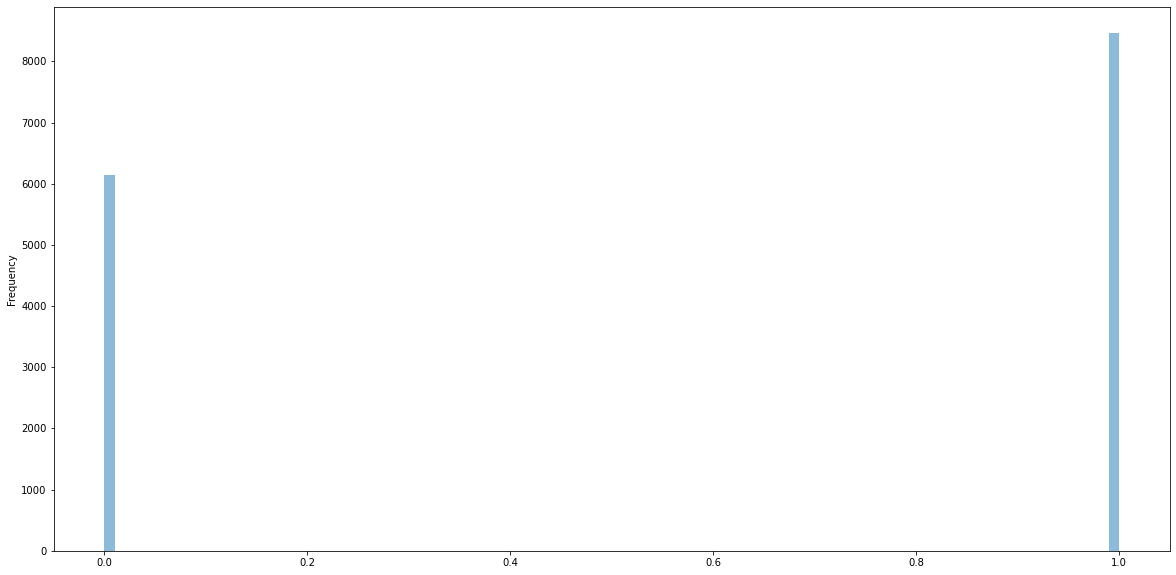

In [10]:
lamoda_labels.gender.plot.hist(alpha=0.5, bins=100, figsize=(20, 10))

As we can see, distribution of sex is not 50/50, so I will divide dataset on train/validation/test not by images count but by classes.

In [11]:
lamoda_labels = lamoda_labels.sample(frac=1).reset_index(drop=True)

In [12]:
def train_test_valid_split(df, gender_id=0):
    df_train = df[:int(.7*len(df))][df.gender==gender_id]
    df_split = df[int(.7*len(df)):][df.gender==gender_id]
    df_valid = df_split[int(.33*len(df_split)):]
    df_test = df_split[:int(.33*len(df_split))]
    return df_train, df_valid, df_test

In [13]:
df_lamoda_train_men, df_lamoda_valid_men, df_lamoda_test_men = train_test_valid_split(lamoda_labels, gender_id=0)

In [14]:
df_lamoda_train_women, df_lamoda_valid_women, df_lamoda_test_women = train_test_valid_split(lamoda_labels, gender_id=1)

In [15]:
assert len(lamoda_labels[lamoda_labels.gender==0]) == len(df_lamoda_train_men) + len(df_lamoda_test_men) + len(df_lamoda_valid_men)

In [16]:
assert len(lamoda_labels[lamoda_labels.gender==1]) == len(df_lamoda_train_women) + len(df_lamoda_test_women) + len(df_lamoda_valid_women)

Asserts are passed.

In [17]:
def move_images_to_dirs(images_list, df, dir_type='train', dir_gender='women', dataset_name='lamoda'):
    for idx in range(len(df)):
        if f"{df.iloc[idx].item_id}.jpg" in images_list:
            shutil.move(f'C:\PythonDev\Projects\sex_clothes_classifier\data\_data\_data\{dataset_name}\images\\' +  f"{df.iloc[idx].item_id}.jpg",
                        f"C:\PythonDev\Projects\sex_clothes_classifier\data\_data\_data\{dir_type}\{dir_gender}\\" + f"{df.iloc[idx].item_id}.jpg")

In [18]:
def move_images_to_dirs(images_list, df, dir_type='train', dir_gender='women', dataset_name='lamoda'):
    for idx in range(len(df)):
        if f"{df.iloc[idx].item_id}.jpg" in images_list:
            shutil.move(f"{SOURCE_PATH}\{dataset_name}\images" +  f"\{df.iloc[idx].item_id}.jpg",
                        f"{SOURCE_PATH}\{dir_type}\{dir_gender}" + f"\{df.iloc[idx].item_id}.jpg")

In [19]:
move_images_to_dirs(images_lamoda, df_lamoda_train_women, dir_type='train', dir_gender='women')
move_images_to_dirs(images_lamoda, df_lamoda_valid_women, dir_type='valid', dir_gender='women')
move_images_to_dirs(images_lamoda, df_lamoda_test_women, dir_type='test', dir_gender='women')
move_images_to_dirs(images_lamoda, df_lamoda_train_men, dir_type='train', dir_gender='men')
move_images_to_dirs(images_lamoda, df_lamoda_valid_men, dir_type='valid', dir_gender='men')
move_images_to_dirs(images_lamoda, df_lamoda_test_men, dir_type='test', dir_gender='men')

In [20]:
images_lamoda_unlabeled = os.listdir(f"{SOURCE_PATH}\lamoda\images")
print(f"Image count, which wasn`t labeled: {len(images_lamoda_unlabeled)}")

Image count, which wasn`t labeled: 916


### Wildberries

In [21]:
images_wildberries =  os.listdir(f"{SOURCE_PATH}\wildberries\images")
print(f"Images count in wildberries dataset: {len(images_wildberries)}")

Images count in wildberries dataset: 1002


In [22]:
wildberries_labels = pd.read_csv(f'{SOURCE_PATH}\wildberries\pages_info.tsv', sep='\t')

In [23]:
wildberries_labels.head()

,gender,category,brand,subcategory,item_url,img_url,item_id,price,price_discount,popular_flg,premium,size,colour,material,novice_flg,rating,num_reviews,description
0,женский,блузка,milanya,блузка,/catalog/50657246/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/50650...,50657246.0,4290.0,1758.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,женский,блузка,victoria veisbrut,блузки,/catalog/47948293/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/47940...,47948293.0,1790.0,1432.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,женский,блузка,aailin,блузка,/catalog/39213396/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/39210...,39213396.0,2200.0,1478.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,женский,блузка,a-a awesome apparel by ksenia avakyan,блузка,/catalog/10147914/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/10140...,10147914.0,1899.0,398.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,женский,блузка,tttextile,блузка,/catalog/33565132/detail.aspx?targetUrl=GP,https://images.wbstatic.net/c516x688/new/33560...,33565132.0,4877.0,2097.0,1,non-premium,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning labels from unrelated for our task entities

In [24]:
wildberries_labels = pd.concat([wildberries_labels.gender, wildberries_labels.item_id], axis=1)
wildberries_labels['gender'][wildberries_labels['gender'] == 'мужской'] = 0
wildberries_labels['gender'][wildberries_labels['gender'] == 'женский'] = 1
wildberries_labels = wildberries_labels.drop(wildberries_labels[wildberries_labels['gender'] == 'женские / для девочек / мом фит / бананы / балоны / багги / слоучи / кюлоты'].index)
wildberries_labels.reset_index(inplace=True)
del wildberries_labels['index']
wildberries_labels['item_id'] = wildberries_labels['item_id'].fillna(0.0).astype(int)
wildberries_labels = wildberries_labels.sample(frac=1).reset_index(drop=True)

<AxesSubplot:ylabel='Frequency'>

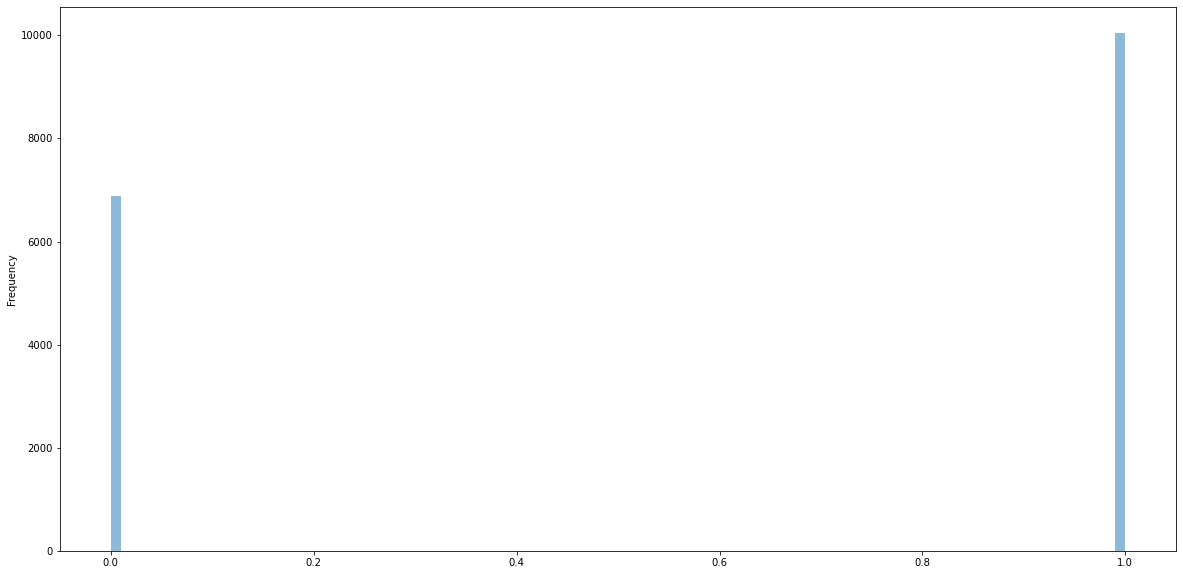

In [25]:
wildberries_labels.gender.plot.hist(alpha=0.5, bins=100, figsize=(20, 10))

In [26]:
df_wildberries_train_men, df_wildberries_valid_men, df_wildberries_test_men = train_test_valid_split(wildberries_labels, gender_id=0)
df_wildberries_train_women, df_wildberries_valid_women, df_wildberries_test_women = train_test_valid_split(wildberries_labels, gender_id=1)

In [27]:
assert len(wildberries_labels[wildberries_labels.gender==0]) == len(df_wildberries_train_men) + len(df_wildberries_valid_men) + len(df_wildberries_test_men)

In [28]:
assert len(wildberries_labels[wildberries_labels.gender==1]) == len(df_wildberries_train_women) + len(df_wildberries_valid_women) + len(df_wildberries_test_women)

In [29]:
move_images_to_dirs(images_wildberries, df_wildberries_train_women, dir_type='train', dir_gender='women', dataset_name='wildberries')
move_images_to_dirs(images_wildberries, df_wildberries_valid_women, dir_type='valid', dir_gender='women', dataset_name='wildberries')
move_images_to_dirs(images_wildberries, df_wildberries_test_women, dir_type='test', dir_gender='women', dataset_name='wildberries')
move_images_to_dirs(images_wildberries, df_wildberries_train_men, dir_type='train', dir_gender='men', dataset_name='wildberries')
move_images_to_dirs(images_wildberries, df_wildberries_valid_men, dir_type='valid', dir_gender='men', dataset_name='wildberries')
move_images_to_dirs(images_wildberries, df_wildberries_test_men, dir_type='test', dir_gender='men', dataset_name='wildberries')

In [30]:
images_wildberries_unlabeled = os.listdir(f"{SOURCE_PATH}\wildberries\images")
print(f"Image count, which wasn`t labeled: {len(images_wildberries_unlabeled)}")

Image count, which wasn`t labeled: 1002


## Dataloader

In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\PythonDev\Projects\sex_clothes_classifier\data\\types_of_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [32]:
image_datasets['valid'].targets = torch.tensor(image_datasets['valid'].targets)
image_datasets['valid'].targets[image_datasets['valid'].targets == 1] = 0
image_datasets['valid'].targets[image_datasets['valid'].targets == 2] = 1
image_datasets['valid'].targets = image_datasets['valid'].targets.tolist()

In [33]:
image_datasets['valid'].targets = torch.tensor(image_datasets['valid'].targets)

In [34]:
torch.tensor(image_datasets['valid'].targets).unique()

tensor([0])

In [35]:
dataloader_train = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4) for x in ['train']}
dataloader_valid = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4) for x in ['valid']}
dataloaders = {**dataloader_train, **dataloader_valid}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
torch.cuda.is_available()

True

In [39]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3080 Laptop GPU'

In [36]:
dataset_sizes

{'train': 177074, 'valid': 49178}

In [37]:
image_datasets['train'].classes

['men', 'women']

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [39]:
image_datasets['valid'].classes

['men', 'women']

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [41]:
model_ft = models.mobilenet_v2(pretrained=False)
model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
model_ft.load_state_dict(torch.load("C:\PythonDev\Projects\sex_clothes_classifier\data\gender classification\gender_classifier_lite.pth"))

<All keys matched successfully>

In [45]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [47]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.0190 Acc: 0.9939
valid Loss: 0.0559 Acc: 0.9852

Epoch 1/2
----------
train Loss: 0.0129 Acc: 0.9958
valid Loss: 0.0585 Acc: 0.9854

Epoch 2/2
----------
train Loss: 0.0112 Acc: 0.9962
valid Loss: 0.0649 Acc: 0.9846

Training complete in 92m 54s
Best val Acc: 0.985420


In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [43]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], title=f"predicted: {class_names[preds[j]]}")

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

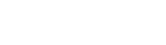

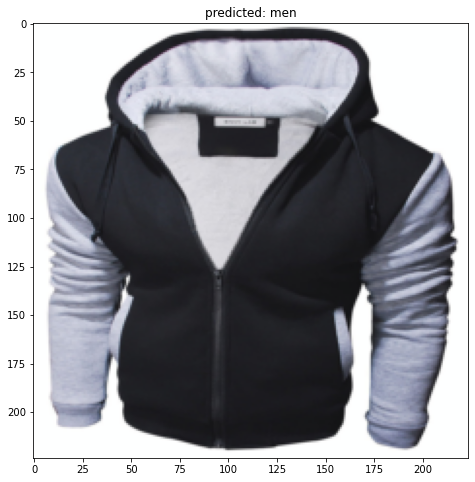

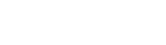

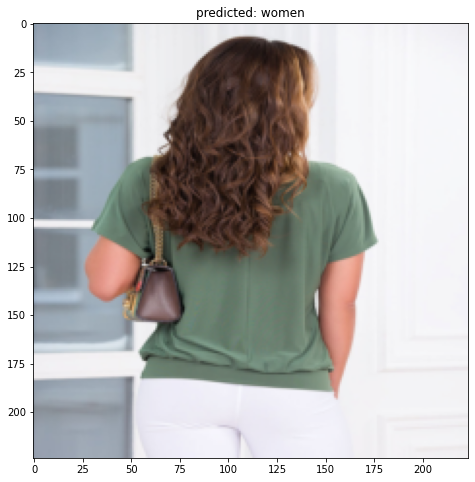

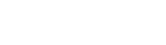

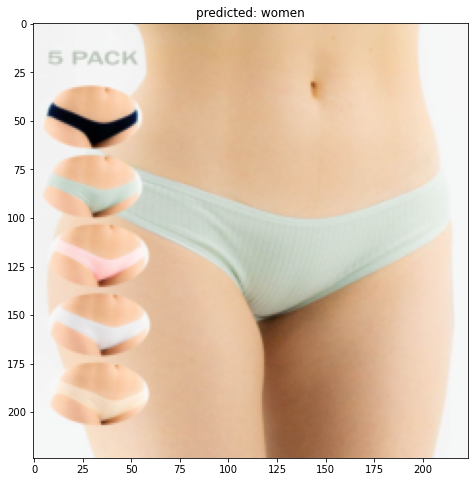

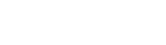

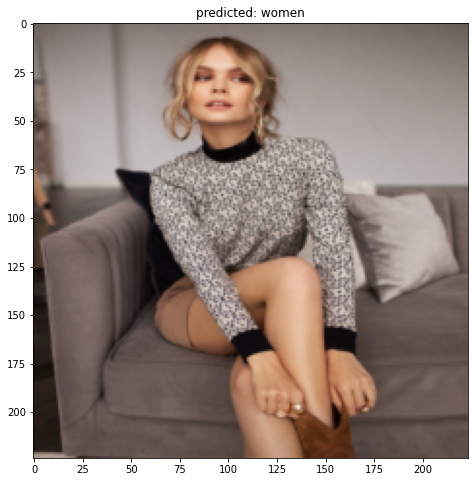

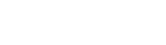

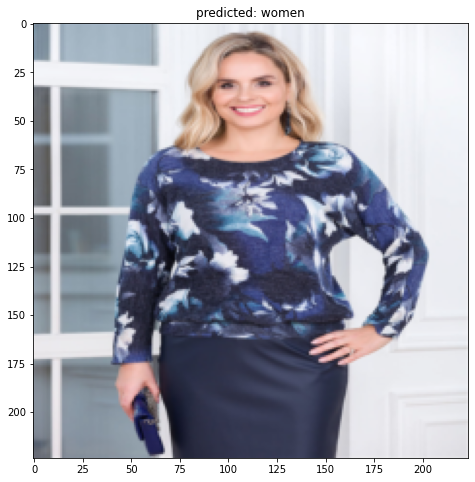

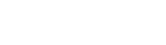

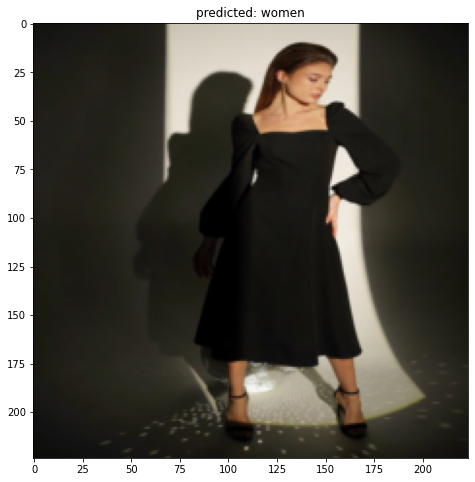

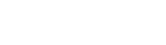

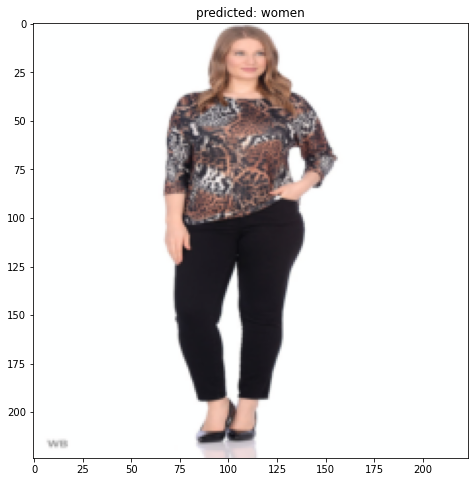

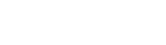

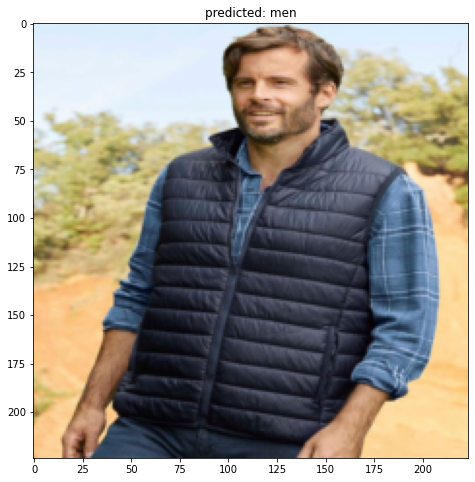

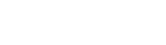

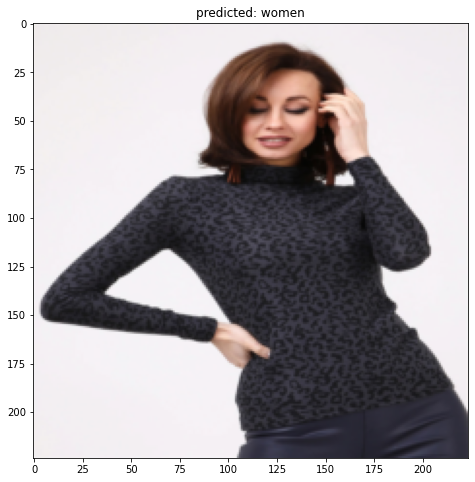

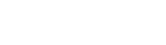

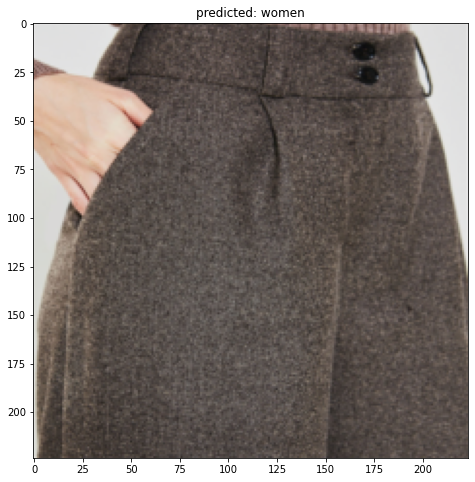

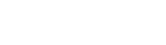

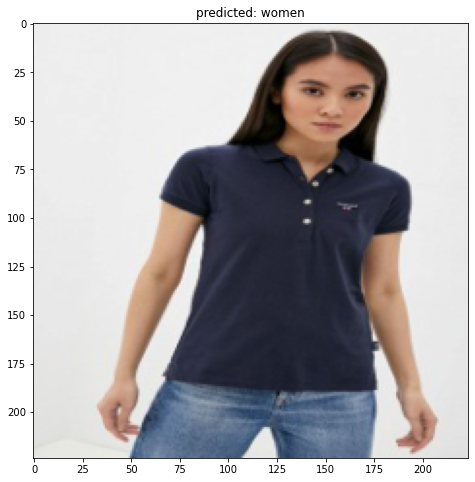

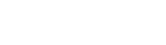

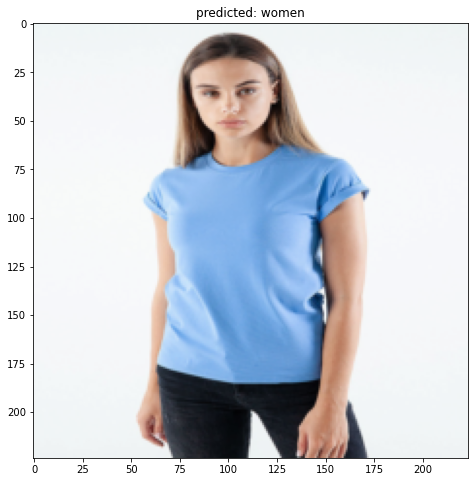

In [46]:
visualize_model(model_ft)

In [57]:
torch.save(model_ft.state_dict(), 'gender_classifier_lite_v_2.pth')

# Optimizing for mobile

In [47]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [48]:
torch.is_vulkan_available()

False

In [ ]:
scripted_model = torch.jit.script(model_ft)
optimized_model = optimize_for_mobile(scripted_model, backend='Vulkan')
print(torch.jit.export_opnames(optimized_model))
optimized_model._save_for_lite_interpreter('./gender_classifier_lite_Vulkan.pt')

In [ ]:
optimized_model

RecursiveScriptModule(
  original_name=MobileNetV2
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ConvBNReLU
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU6)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNReLU
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(original_name=Conv2d)
        (2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
    )
    (2): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
     